In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
!gdown --id 1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
!gdown --id 1bs8PHTExPfItW636-HVRVYwjjPilQVgy

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1s2ggWGqAjB-wlXkd6Pu7pM_3kqs6RhAF
To: /content/id_map.parquet
100% 1.20M/1.20M [00:00<00:00, 74.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQCM32OzxqvmDsgL5j4et-yE5W8o6afE
To: /content/train.csv
42.9MB [00:00, 118MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1bs8PHTExPfItW636-HVRVYwjjPilQVgy
To: /content/test.csv
24.8MB [00:00, 93.7MB/s]


In [2]:
# !pip install imbalanced-learn
!pip install scikit-learn==0.24
!pip install catboost
!pip install tldextract
!pip install eli5
!pip install mlrose
!pip install category_encoders

     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 67.4 MB 52 kB/s 
     |████████████████████████████████| 87 kB 2.3 MB/s 
     |████████████████████████████████| 106 kB 3.3 MB/s 
     |████████████████████████████████| 80 kB 3.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import time
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier

import re
from wordcloud import WordCloud
from tldextract import extract
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

import six
# import sys
# sys.modules['sklearn.externals.six'] = six
# import mlrose

# import sklearn.neighbors._base
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
# sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

# from imblearn.pipeline import Pipeline as imb_make_pipeline
# from imblearn.combine import SMOTETomek 
# from imblearn.over_sampling import SMOTENC
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.under_sampling import TomekLinks

from category_encoders import TargetEncoder

In [4]:
import eli5
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit
from numpy import mean
from scipy.sparse import hstack
from numpy import std
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Support

In [5]:
def time_feature_extraction(data, train_flag):

    data = data.assign(
        # session start time
        session_start=lambda x: x.filter(like='time').min(axis=1),
        # session end time
        session_end=lambda x: x.filter(like='time').max(axis=1),
        # session duration
        duration=lambda x: (x.session_end - x.session_start).dt.seconds,
        # start hour in a session
        start_hour=lambda x: x.session_start.apply(lambda x: x.hour).astype('category'),
        # day of week in a session
        weekday=lambda x: x.session_start.apply(lambda x: x.dayofweek).astype('category'),

        # count_of_nans
        nans_count=lambda x: x.filter(like='webpage').isna().sum(axis=1),
        # nunique pages
        nunique_pages=lambda x: x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count)
        )

    data.loc[data["duration"]==0, "duration"] = 0.01
    data["duration"], lmbda = stats.boxcox(data.loc[:, "duration"])

    data["time"] = "none"
    data.loc[data["start_hour"].isin([15,16,17,18,19,3]), "time"] = "first"
    data.loc[data["start_hour"].isin([4,5,6,7]), "time"] = "second"
    data.loc[data["start_hour"].isin([8,9]), "time"] = "third"
    data.loc[data["start_hour"].isin([10,11]), "time"] = "fourth"
    data.loc[data["start_hour"].isin([12,13,14]), "time"] = "fifth"

    if train_flag:
        data = data.reset_index().sort_values(['session_start', "session_id"], ignore_index=True)
        data.drop(columns=["session_start", "session_end"], inplace=True)
    else:
        data.drop(columns=["session_start", "session_end"], inplace=True)
    return data

In [6]:
def intersection(train, id_map):
    data_train = merge_data_and_domain(train, id_map).loc[:, ['webpage_update%s' % i for i in range(1, 11)]+["start_hour", "weekday"]]

    data_train.loc[:, ['webpage_update%s' % i for i in range(1, 11)]] = data_train.loc[:, ['webpage_update%s' % i for i in range(1, 11)]].fillna("")
    data_train.loc[:, "string"] = data_train.apply(lambda x: "-".join([x[i] for i in range(0,10) if x[i] != ""]), axis=1)
    data_train.loc[:, "preproc_tokens"] = data_train.loc[:, "string"].apply(lambda x: x.split('-')).values

    data_train = data_train.loc[:, ["preproc_tokens"]]

    data_train.loc[:, [".youtube", "sn gxouxg jqbe.googlevideo", ".ytimg"]] = 0

    for token in [".youtube", "sn gxouxg jqbe.googlevideo", ".ytimg"]:
        data_train[token] = data_train.loc[:, "preproc_tokens"].apply(lambda x: 1 if token in x else 0)
    data_train["intersection"] = 0
    data_train.loc[(data_train[".youtube"]==1) & (data_train["sn gxouxg jqbe.googlevideo"]==1) & (data_train[".ytimg"]==1), "intersection"] = 1

    train = pd.concat([train, data_train.loc[:, ["intersection"]]], axis=1)

    return train

In [7]:
def popular_webpage_features_train(data):
    for webpage_number in range(1,11):
        if webpage_number == 1:
            df = data[['session_id',f'webpage{webpage_number}','target']]
            df.columns = ['session_id','webpage', 'target']
        if webpage_number!=1:
            next = data[['session_id',f'webpage{webpage_number}', 'target']]
            next.columns = ['session_id','webpage', 'target']
            df = pd.concat([df, next], ignore_index=True)
    # check target share
    webpage_mean = df.groupby('webpage')['target'].mean()
    # check sum
    webpage_sum = df.groupby('webpage')['target'].sum()
    webpage = pd.merge(webpage_mean, webpage_sum, left_index=True, right_index=True)
    # share * sum
    webpage["target_value"] = webpage["target_x"] * webpage["target_y"]
    webpage.sort_values(inplace=True, by=["target_value"])
    webpage = webpage.loc[webpage["target_x"]>0]
    webpage["target_value_log"] = np.log(webpage.loc[:, "target_value"])
    important_pages = webpage.loc[webpage["target_x"]>0.9].index.astype(int).values
    webpage = webpage.loc[webpage["target_x"]<0.9]
    quantiles = webpage["target_value_log"].quantile([.4, 0.7, 0.95]).values

    count = 0
    for quantile in quantiles:
        count += 1
        pages = webpage.loc[webpage["target_value_log"]>quantile].index.astype(int).values
        pages = list(pages) + list(important_pages)
        data.loc[:, f'popular_pages_{count}'] = 0
        for col in [f"webpage{i}" for i in range(1,11)]:
            data.loc[data[col].isin(pages), f'popular_pages_{count}'] = 1

    return data, quantiles, webpage, important_pages

def popular_webpage_features_test(data, quantiles, webpage, important_pages):
    count = 0
    for quantile in quantiles:
        count += 1
        pages = webpage.loc[webpage["target_value_log"]>quantile].index.astype(int).values
        pages = list(pages) + list(important_pages)
        data.loc[:, f'popular_pages_{count}'] = 0
        for col in [f"webpage{i}" for i in range(1,11)]:
            data.loc[data[col].isin(pages), f'popular_pages_{count}'] = 1
    return data

In [8]:
def remove_days(data):
    
    data = data.set_index('session_id')
    
    bad_hours_array = np.array([3, 6, 15, 16, 17, 18, 19])
    good_hours_array = np.array([4, 5, 7, 8, 9, 10, 11, 12, 13, 14])
    good_session_id = data[data.start_hour.isin(good_hours_array)].index
    bad_session_id = data[data.start_hour.isin(bad_hours_array)].index
    
    data = data.loc[good_session_id]
    data = data.reset_index()
    
    return data, good_session_id, bad_session_id

In [9]:
def text_preprocessing_1(text):
    # split text by . or -
    clean_text = re.split("\.|-", text)
    # join text
    clean_text = " ".join(clean_text)
    # remove nums
    clean_text = re.sub("[0-9]", "", clean_text)
    # remove spaces
    clean_text = re.sub(' +', ' ', clean_text)
    # split
    clean_text = re.split(" ", clean_text)
    # seq must be longer then 1
    clean_text = [x for x in clean_text if len(x)>1]
    # join text
    clean_text = " ".join(clean_text)

    return clean_text

In [10]:
def merge_data_and_domain(data, id_map):
    for i in range(1,11):
        data = pd.merge(data, id_map.rename(columns={"id":"webpage"+str(i), 
                                                     "webpage_update":"webpage_update"+str(i)}).loc[:, ["webpage"+str(i),
                                                                                                        "webpage_update"+str(i)]], 
                        on="webpage"+str(i), how="left")
    return data
    
def tf_idf_features(train, test, vectorizer_params):

    webpages_update = ['webpage_update%s' % i for i in range(1, 11)]

    train_sessions = train.loc[:, webpages_update].fillna("")
    test_sessions = test.loc[:, webpages_update].fillna("")

    train_tokens = train_sessions.apply(lambda x: "-".join([x[i] for i in range(0,10) if x[i] != ""]), axis=1)
    test_tokens = test_sessions.apply(lambda x: "-".join([x[i] for i in range(0,10) if x[i] != ""]), axis=1)

    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_tokens)
    X_test = vectorizer.transform(test_tokens)
    
    return X_train, X_test, vectorizer

In [11]:
def train_word2vec(train_domain_features, test_domain_features, 
                   size, window, min_count, workers, sg):
    
    webpages_update = ['webpage_update%s' % i for i in range(1, 11)]

    train_domain_features = train_domain_features.loc[:, webpages_update].fillna("")
    test_domain_features = test_domain_features.loc[:, webpages_update].fillna("")
    
    train_domain_features.loc[:, "string"] = train_domain_features.apply(lambda x: "-".join([x[i] for i in range(0,10) if x[i] != ""]), axis=1)
    test_domain_features.loc[:, "string"] = test_domain_features.apply(lambda x: "-".join([x[i] for i in range(0,10) if x[i] != ""]), axis=1)

    train_domain_features.loc[:, "preproc_tokens"] = train_domain_features.loc[:, "string"].apply(lambda x: x.split('-')).values
    test_domain_features.loc[:, "preproc_tokens"] = test_domain_features.loc[:, "string"].apply(lambda x: x.split('-')).values

    # Store the model in following file
    word2vec_model_file = OUTPUT_FOLDER + '/word2vec_' + str(size) + '.model'
    # Store the vectors for train data in following file
    word2vec_filename = OUTPUT_FOLDER + '/train_review_word2vec.csv'

    start_time = time.time()
    preproc_tokens = pd.Series(train_domain_features['preproc_tokens']).values
    # Train the Word2Vec Model
    w2v_model = Word2Vec(preproc_tokens, min_count=min_count, size=size, workers=workers, window=window, sg=sg)
    print(f"Time taken to train word2vec model: {(time.time() - start_time)/60:0.03} min")
    # save model to file
    w2v_model.save(word2vec_model_file)

    # save emb to file
    with open(word2vec_filename, 'w+') as word2vec_file:
        print("data shape: ", train_domain_features.shape[0])
        for index, row in tqdm_notebook(train_domain_features.iterrows()):
            model_vector = (np.mean([w2v_model[token] for token in row['preproc_tokens']], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(x) for x in range(size))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            # Check if the line exists else it is vector of zeros
            if type(model_vector) is list:  
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(size)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')

    # Load train from the filename
    word2vec_train = pd.read_csv(word2vec_filename)

    test_features_word2vec = np.array([x for x in range(size)])
    test_ = np.array([0 for x in range(size)])
    print("data shape: ", test_domain_features.shape[0])
    for index, row in tqdm_notebook(test_domain_features.iterrows()):
        model_vector = np.mean([w2v_model[token] for token in row['preproc_tokens'] if token in w2v_model.wv.vocab], axis=0)
        if type(model_vector) is np.ndarray:
            test_ = np.vstack([test_, model_vector])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
        else:
            test_ = np.vstack([test_, np.array([0 for i in range(size)])])
            if test_.shape[0] > 500:
                test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])
                test_ = np.array([0 for x in range(size)])
    test_features_word2vec = np.vstack([test_features_word2vec, test_[1:]])

    word2vec_test = pd.DataFrame(test_features_word2vec[1:])

    return word2vec_train, word2vec_test

In [12]:
def extraction(train, x_test, id_map, vectorizer_params, 
               time_features, popular_features, remove_obs, 
               columns_tf_idf, tf_idf, word2vec, tf_w2v):

    if time_features:      
        print("extract time features")    
        train = time_feature_extraction(train, train_flag=True)
        x_test = time_feature_extraction(x_test, train_flag=False)

        print("intersection features") 
        train = intersection(train.copy(), id_map.copy())
        x_test = intersection(x_test, id_map)

    if popular_features:
        print("extract popularity features")  
        train, quantiles, webpage, important_pages = popular_webpage_features_train(train)
        x_test = popular_webpage_features_test(x_test, quantiles, webpage, important_pages)

    if remove_obs:
        print("remove_obs")  
        # можно выкинуть дополнительно 3 часа, потеряв 5 наблюдений класса
        train, good_ids_train, bad_ids_train = remove_days(train.copy())

    if tf_idf | tf_w2v:
        print("apply tf idf")  
        data_train = merge_data_and_domain(train, id_map).loc[:, ['webpage_update%s' % i for i in range(1, 11)]]
        data_test = merge_data_and_domain(x_test, id_map).loc[:, ['webpage_update%s' % i for i in range(1, 11)]]
        train_tf_idf, test_tf_idf, vectorizer = tf_idf_features(train=data_train, test=data_test, vectorizer_params=vectorizer_params)
        train_tf_idf = pd.DataFrame.sparse.from_spmatrix(train_tf_idf, 
                                                         columns=vectorizer.get_feature_names(), 
                                                         index=train.set_index("session_id").index)
        train_tf_idf = train_tf_idf.loc[:, columns_tf_idf]
        test_tf_idf = pd.DataFrame.sparse.from_spmatrix(test_tf_idf, 
                                                        columns=vectorizer.get_feature_names(), 
                                                        index=x_test.set_index("session_id").index)
        test_tf_idf = test_tf_idf.loc[:, columns_tf_idf]

    if word2vec | tf_w2v:
        print("word2vec")  
        data_train = merge_data_and_domain(train, id_map).loc[:, ['webpage_update%s' % i for i in range(1, 11)]]
        data_test = merge_data_and_domain(x_test, id_map).loc[:, ['webpage_update%s' % i for i in range(1, 11)]]
        word2vec_train, word2vec_test = train_word2vec(data_train, data_test, size=175, window=2, 
                                                       min_count=1, workers=3, sg=1)
        columns_2 = word2vec_train.columns
        word2vec_train.index = train.set_index("session_id").index
        word2vec_test.index = x_test.set_index("session_id").index

    # set_index
    train.set_index("session_id", inplace=True)
    x_test.set_index("session_id", inplace=True)

    x_train, y_train = train.drop(columns=["target"]), train.loc[:, ["target"]]

    # drop useless features
    other_features_list = ["webpage"+str(i) for i in range(1,11)] + ["time"+str(i) for i in range(1,11)]
    x_train.drop(columns=other_features_list, inplace=True)
    x_test.drop(columns=other_features_list, inplace=True)

    encoder = OneHotEncoder(handle_unknown="ignore")
    features_dummy_train = encoder.fit_transform(x_train.loc[:, ["time", "weekday", "nans_count"]])
    features_dummy_train = pd.DataFrame.sparse.from_spmatrix(features_dummy_train, index=x_train.index)
    features_dummy_test = encoder.transform(x_test.loc[:, ["time", "weekday", "nans_count"]])
    features_dummy_test = pd.DataFrame.sparse.from_spmatrix(features_dummy_test, index=x_test.index)

    cat_columns = list(range(features_dummy_test.shape[1]))

    x_train.drop(columns=["start_hour", "weekday", "nans_count", "time"], inplace=True)
    x_test.drop(columns=["start_hour", "weekday", "nans_count", "time"], inplace=True)

    x_train = pd.concat([features_dummy_train, x_train], axis=1)
    columns = x_train.columns
    x_test = pd.concat([features_dummy_test, x_test], axis=1)

    if tf_w2v:
        x_train = pd.concat([x_train, train_tf_idf], axis=1)
        x_test = pd.concat([x_test, test_tf_idf], axis=1)

        x_train = pd.concat([x_train, word2vec_train], axis=1)
        x_test = pd.concat([x_test, word2vec_test], axis=1)
        return x_train, y_train, x_test, vectorizer, columns, columns_2, cat_columns
    if tf_idf:
        x_train = pd.concat([x_train, train_tf_idf], axis=1)
        x_test = pd.concat([x_test, test_tf_idf], axis=1)
        return x_train, y_train, x_test, vectorizer, columns, cat_columns
    elif word2vec:
        x_train = pd.concat([x_train, word2vec_train], axis=1)
        x_test = pd.concat([x_test, word2vec_test], axis=1)
        return x_train, y_train, x_test, columns, columns_2, cat_columns
    else:
        return x_train, y_train, x_test, columns, cat_columns

In [13]:
def cv_curve(param_name, mean_test, std_test, mean_train, std_train, param_val, x_type, param_scale="log"):
    #try:
    #    param_val.sort()
    #except:
    #    pass
    lower_b_tt = mean_test - 2*std_test
    upper_b_tt= mean_test + 2*std_test
    
    lower_b_tn = mean_train - 2*std_train
    upper_b_tn = mean_train + 2*std_train
    
    f = plt.figure(figsize=(13,5))
    plt.title('choose ' + param_name)
    
    if x_type == 'O':
        plt.plot(range(len(param_val)), mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(range(len(param_val)), lower_b_tt, label='test lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tt, label='test upper bound', color='b', lw=2, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)

        plt.plot(range(len(param_val)), mean_train, label='train mean values of score', color='gray', lw=1)
        plt.plot(range(len(param_val)), lower_b_tn, label='train lower bound', color='gray', lw=1, linestyle='dashed')
        plt.plot(range(len(param_val)), upper_b_tn, label='train upper bound', color='gray', lw=1, linestyle='dashed')
        plt.xticks(range(len(param_val)), param_val)
    else:
        if param_scale =='log':
            plt.xscale('log')
        plt.plot(param_val, mean_test, label='test mean values of score', color='r', lw=3)
        plt.plot(param_val, lower_b_t, label='lower bound', color='b', lw=2, linestyle='dashed')
        plt.plot(param_val, upper_b_t, label='upper bound', color='b', lw=2, linestyle='dashed')
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor('white')
    legend_box.set_edgecolor('red')
    plt.xlabel('parameter')
    plt.ylabel('roc_auc')
    plt.show()

In [14]:
def save_submission(pred, number):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/submissions_test/notebook_submission' + str(number) + '.csv')

In [15]:
    # smote = SMOTENC(categorical_features=categorical_features, sampling_strategy=0.05)
    # sampler_3 = SMOTETomek(smote=smote)
    # sampler = RandomUnderSampler(sampling_strategy=0.025)

        # estimator_lr = imb_make_pipeline(steps = [
    #                                         ('RandomUnderSampler', sampler),
    #                                         ('model_fitting', logreg)
    #                                         ])

In [33]:
def train_function(x_train, y_train, categorical_features, logreg,
                   rf, lgbm, catboost):
    time_split = TimeSeriesSplit(n_splits=7)

    if logreg:
        estimator = LogisticRegression(random_state=42, solver='liblinear', penalty="l2")
        param_grid = {
            'C': [1, 3, 9, 27],
        }
    
    if rf:
        estimator = RandomForestClassifier(random_state=42, n_estimators=275, 
                                           min_samples_leaf=2)
        param_grid = {
            'max_depth'         : [9, 15],
            'max_features'      : [5, 10, 'auto'],
            'min_samples_split' : [2, 6, 12],
        }

    if lgbm:
        estimator = LGBMClassifier(random_state=42, is_unbalance=True)
        param_grid = {
            'num_leaves'    : [15, 31, 100],
            'n_estimators'  : [100, 200, 350],
        }

    if catboost:
        estimator = CatBoostClassifier(learning_rate=0.01, metric_period=20,
                                       auto_class_weights = "Balanced",
                                       loss_function = "Logloss")
        
        param_grid = {
            'depth'         : [5, 10, 20],
            'l2_leaf_reg'   : [3, 6, 10],
            "iterations"    : [150, 200, 250]}

    # Определяем Поиск по сети
    clf = GridSearchCV(estimator, 
                    param_grid=param_grid, 
                    scoring='roc_auc', 
                    cv = time_split, 
                    return_train_score=True,
                    verbose=2,
                    n_jobs=1
                    )
    print("fitting GridSearchCV")
    # Обучаем clf
    clf.fit(x_train, y_train)

    print(clf.best_params_)

    cv_scores = cross_val_score(clf.best_estimator_, x_train, y_train, 
                                cv=time_split, scoring='roc_auc', n_jobs=1)
    
    print(f"cv_scores: {cv_scores}")
    print("mean: ", cv_scores.mean())

    return clf, cv_scores


# Preprocessing

In [17]:
list_positive = ['.express', '.info jeunes', '.vk', '.melty', 'fr web img.acsta',
       '.videostep', 'khms.google', '.radio canada', 'api.bing',
       '.banque chalus', '.audienceinsights', 'demotivateur.disqus',
       '.indeed', 'media.melty', '.video', '.jobisjob', '.blogger',
       'gujynbgx.admedia', '.youwatch', 'reviewer.lavoixdunord',
       'img wikia.nocookie', 'static.programme tv', 'static.flickr',
       '.audienceinsights facebook', '.regarder film gratuit', '.bbc',
       '.', 'facebook .audienceinsights', 'static.videostep', '.exashare',
       '.blastr', '.brgm', 'docs.google', 'graphics.nytimes', '.reddit',
       'id.google', 'fr glee.wikia', '.caf','cdn.freepik', 'betacie.cachefly',
       'clients.google .google .google .google', 'sn gkued.googlevideo',
       'twitter .demotivateur', '.demotivateur', 'storage.canalblog',
       '.ajoutezvotresite', '.hellopro', 'wwwd.caf', 'www auvergne.afpa']

list_neg = ['.futura sciences', 'clients.google clients.google clients.google',
'fr mg mail.yahoo', '.ztat', 'fbstatic.akamaihd', '.spin',
'facebook', 'ba.commentcamarche', 'static.ccm',
'safebrowsing cache.google', '.linkedin', '.wordreference',
'fr.openclassrooms', '.bing', 'clients.google clients.google', 'mail.google', 'plus.google']

features_list = list_positive + list_neg

In [18]:
OUTPUT_FOLDER = "/content/gdrive/MyDrive/EPAM/Week 7. Trees/HW/model_test"

In [19]:
train = pd.read_csv("./train.csv", index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
x_test = pd.read_csv('./test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
x_test.reset_index(inplace=True)
id_map = pd.read_parquet("/content/id_map.parquet")

In [20]:
# get user's webpages 
user_frame = train.loc[train["target"]==1].reset_index(drop=True)

array = np.array([])
for element in ["webpage"+str(x) for x in range(1,11)]:
    unique_array = user_frame.loc[:, element].unique()
    array = np.concatenate([array, unique_array])
array = {x for x in array if x==x}

id_map["target"] = 0
id_map.loc[id_map["id"].isin(array), "target"] = 1

# extract "sub-domain", "domain", "suf" from url of webpage
list_ = [list(extract(id_map.loc[i].webpage)) for i in id_map.index]
id_map.loc[:, ["sub","domain","suf"]] = list_

# url preprocessing
id_map.loc[:, "domain"] = [text_preprocessing_1(text=x) for x in id_map.loc[:, "domain"].values]
id_map.loc[:, "sub"] = [text_preprocessing_1(text=x) for x in id_map.loc[:, "sub"].values]
id_map.loc[:, "sub"] = id_map.loc[:, "sub"].apply(lambda x: "" if x in ["www", "js init"] else x)
id_map["webpage_update"] = id_map.apply(lambda x: ".".join([x[3], x[4]]), axis=1)
id_map.loc[:, "webpage_update"] = id_map.loc[:, "webpage_update"].apply(lambda x: "twitter" if x in [".twitter", "platform.twitter"] else x)
id_map.loc[:, "webpage_update"] = id_map.loc[:, "webpage_update"].apply(lambda x: "facebook" if x in ["static ak.facebook", ".facebook", "connect.facebook"] else x)

In [ ]:
# sufs = pd.DataFrame(id_map[["target", "suf"]].value_counts(), columns=["count"]).reset_index()

# LogReg

In [ ]:
vectorizer_params={'ngram_range': (1, 5), 
                   'max_features': 30000,
                   "min_df": 2,
                   "max_df": 0.7,
                   'tokenizer': lambda s: s.split("-")
                   }

In [ ]:
# time_features + popular_features
x_train2, y_train2, x_test2, columns2, cat_columns2 = extraction(train=train.copy(), x_test=x_test.copy(), id_map=id_map, 
                                    vectorizer_params=vectorizer_params, time_features=True,
                                    popular_features=True, remove_obs=False, columns_tf_idf = features_list,
                                    tf_idf=False, word2vec=False, tf_w2v=False)

extract time features
extract popularity features


In [ ]:
# time_features + popular_features + tf_idf
x_train5, y_train5, x_test5, vectorizer5, columns5, cat_columns5 = extraction(train=train.copy(), x_test=x_test.copy(), id_map=id_map, 
                                    vectorizer_params=vectorizer_params, time_features=True,
                                    popular_features=True, remove_obs=False, columns_tf_idf = features_list,
                                    tf_idf=True, word2vec=False, tf_w2v=False )

extract time features
intersection features
extract popularity features
apply tf idf
Index([                0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8,
                       9,                10,                11,
                      12,                13,                14,
                      15,                16,                17,
                      18,                19,                20,
                      21,        'duration',   'nunique_pages',
          'intersection', 'popular_pages_1', 'popular_pages_2',
       'popular_pages_3'],
      dtype='object')


In [ ]:
# time_features + popular_features + word2vec
x_train6, y_train6, x_test6, vectorizer6, columns6_1, columns6_2, cat_columns6 = extraction(train=train.copy(), x_test=x_test.copy(), id_map=id_map, 
                                                                                vectorizer_params=vectorizer_params, time_features=True,
                                                                                popular_features=True, remove_obs=False, columns_tf_idf = features_list,
                                                                                tf_idf=False, word2vec=False, tf_w2v=True)

extract time features
intersection features
extract popularity features
apply tf idf
word2vec
Time taken to train word2vec model: 0.394 min
data shape:  159969


0it [00:00, ?it/s]

data shape:  93338


0it [00:00, ?it/s]

Index([                0,                 1,                 2,
                       3,                 4,                 5,
                       6,                 7,                 8,
                       9,                10,                11,
                      12,                13,                14,
                      15,                16,                17,
                      18,                19,                20,
                      21,        'duration',   'nunique_pages',
          'intersection', 'popular_pages_1', 'popular_pages_2',
       'popular_pages_3'],
      dtype='object')


In [ ]:
estimator_5, cv_scores_5 = train_function(x_train=x_train5, y_train=y_train5, categorical_features=cat_columns5)

fitting GridSearchCV
Fitting 7 folds for each of 4 candidates, totalling 28 fits
[CV] END ................................................C=1; total time=   0.3s
[CV] END ................................................C=1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.8s
[CV] END ................................................C=1; total time=   1.1s
[CV] END ................................................C=1; total time=   1.4s
[CV] END ................................................C=1; total time=   1.6s
[CV] END ................................................C=1; total time=   2.0s
[CV] END ................................................C=3; total time=   0.3s
[CV] END ................................................C=3; total time=   0.6s
[CV] END ................................................C=3; total time=   0.9s
[CV] END ................................................C=3; total time=   1.3s
[CV] END ...................

In [ ]:
estimator_6, cv_scores_6 = train_function(x_train=x_train6, y_train=y_train6, categorical_features=cat_columns6)

fitting GridSearchCV
Fitting 7 folds for each of 4 candidates, totalling 28 fits
[CV] END ................................................C=1; total time=   1.8s
[CV] END ................................................C=1; total time=   4.1s
[CV] END ................................................C=1; total time=   7.2s
[CV] END ................................................C=1; total time=  10.2s
[CV] END ................................................C=1; total time=  13.0s
[CV] END ................................................C=1; total time=  14.8s
[CV] END ................................................C=1; total time=  21.5s
[CV] END ................................................C=3; total time=   2.0s
[CV] END ................................................C=3; total time=   5.4s
[CV] END ................................................C=3; total time=   8.7s
[CV] END ................................................C=3; total time=  14.9s
[CV] END ...................

In [ ]:
# eli5.show_weights(estimator=estimator_5, feature_names=[str(x) for x in columns5]+vectorizer5.get_feature_names(), top=50)

In [ ]:
estimator_6_pred = estimator_6.predict_proba(x_test6)[:, 1]
save_submission(estimator_6_pred, number=24)

# Trees

In [21]:
vectorizer_params={'ngram_range': (1, 5), 
                   'max_features': 30000,
                   "min_df": 2,
                   "max_df": 0.7,
                   'tokenizer': lambda s: s.split("-")
                   }

In [22]:
# time_features + popular_features
x_train1, y_train1, x_test1, vectorizer1, columns1, cat_columns1 = extraction(train=train.copy(), x_test=x_test.copy(), id_map=id_map, 
                                                                            vectorizer_params=vectorizer_params, time_features=True,
                                                                            popular_features=True, remove_obs=False, columns_tf_idf = features_list,
                                                                            tf_idf=True, word2vec=False, tf_w2v=False)

extract time features
intersection features
extract popularity features
apply tf idf


In [23]:
# time_features + popular_features
x_train2, y_train2, x_test2, vectorizer2, columns2_1, columns2_2, cat_columns2 = extraction(train=train.copy(), x_test=x_test.copy(), id_map=id_map, 
                                                                                            vectorizer_params=vectorizer_params, time_features=True,
                                                                                            popular_features=True, remove_obs=False, columns_tf_idf = features_list,
                                                                                            tf_idf=False, word2vec=False, tf_w2v=True)

extract time features
intersection features
extract popularity features
apply tf idf
word2vec
Time taken to train word2vec model: 0.256 min
data shape:  159969


0it [00:00, ?it/s]

data shape:  93338


0it [00:00, ?it/s]

## RF

In [ ]:
estimator_rf_1, cv_scores_rf_1 = train_function(x_train=x_train1, y_train=y_train1, categorical_features=cat_columns1, 
                                                logreg=False, rf=True, lgbm=False, catboost=False)

In [ ]:
cv_scores_rf_1

array([0.94293911, 0.88928795, 0.94321678, 0.96663603, 0.89947773,
       0.94914486, 0.98430882])

In [ ]:
estimator_rf_2, cv_scores_rf_2 = train_function(x_train=x_train2, y_train=y_train2, categorical_features=cat_columns1, 
                                                logreg=False, rf=True, lgbm=False, catboost=False)

In [ ]:
cv_scores_rf_2

In [ ]:
# CV curves
rs_df = pd.DataFrame(estimator_rf_2.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)
mean_train_score_var_2  = rs_df.loc[0, 'mean_train_score']

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

## LGBMClassifier

In [ ]:
estimator_lgbm_1, cv_scores_lgbm_1 = train_function(x_train=x_train1, y_train=y_train1, categorical_features=cat_columns1, 
                                                    logreg=False, rf=False, lgbm=True, catboost=False)

In [ ]:
cv_scores_lgbm_1

In [ ]:
# CV curves
rs_df = pd.DataFrame(estimator_lgbm_1.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)
mean_train_score_var_2  = rs_df.loc[0, 'mean_train_score']

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [29]:
from pandas.api.types import is_sparse
for column in x_train2.columns:
    if is_sparse(x_train2[column]):
        x_train2.loc[:, column] = x_train2.loc[:, column].sparse.to_dense()

In [34]:
estimator_lgbm_2, cv_scores_lgbm_2 = train_function(x_train=x_train2, y_train=y_train2, categorical_features=cat_columns1, 
                                                    logreg=False, rf=False, lgbm=True, catboost=False)

fitting GridSearchCV
Fitting 7 folds for each of 9 candidates, totalling 63 fits
[CV] END ....................n_estimators=100, num_leaves=15; total time=   2.8s
[CV] END ....................n_estimators=100, num_leaves=15; total time=   3.8s
[CV] END ....................n_estimators=100, num_leaves=15; total time=   4.8s
[CV] END ....................n_estimators=100, num_leaves=15; total time=   6.1s
[CV] END ....................n_estimators=100, num_leaves=15; total time=   7.3s
[CV] END ....................n_estimators=100, num_leaves=15; total time=   8.0s
[CV] END ....................n_estimators=100, num_leaves=15; total time=   9.6s
[CV] END ....................n_estimators=100, num_leaves=31; total time=   3.3s
[CV] END ....................n_estimators=100, num_leaves=31; total time=   5.3s
[CV] END ....................n_estimators=100, num_leaves=31; total time=   6.4s
[CV] END ....................n_estimators=100, num_leaves=31; total time=   8.1s
[CV] END ...................

In [35]:
cv_scores_lgbm_2

array([0.9271076 , 0.87695905, 0.85885633, 0.91664418, 0.95499773,
       0.90677033, 0.97830598])

In [37]:
param_grid = {
            'num_leaves'    : [15, 31, 100],
            'n_estimators'  : [100, 200, 350],
        }

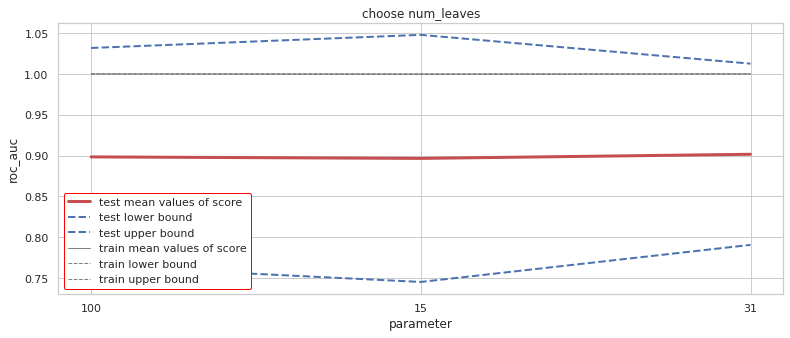

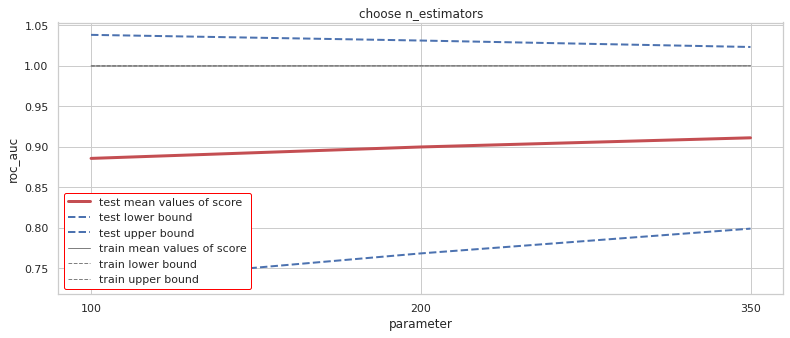

In [38]:
# CV curves
rs_df = pd.DataFrame(estimator_lgbm_2.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)
mean_train_score_var_2  = rs_df.loc[0, 'mean_train_score']

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [49]:
from pandas.api.types import is_sparse
for column in x_test2.columns:
    if is_sparse(x_test2[column]):
        x_test2.loc[:, column] = x_test2.loc[:, column].sparse.to_dense()

In [48]:
x_test2.columns = list(range(0, x_test2.shape[1]))

In [51]:
lgbm_2_pred = estimator_lgbm_2.best_estimator_.predict_proba(x_test2)[:, 1]
save_submission(lgbm_2_pred, number=26)

## CatBoostClassifier

In [ ]:
estimator_cat_1, cv_scores_cat_1 = train_function(x_train=x_train1, y_train=y_train1, categorical_features=cat_columns1, 
                                                    logreg=False, rf=False, lgbm=False, catboost=True)

In [ ]:
cv_scores_cat_1

In [ ]:
# CV curves
rs_df = pd.DataFrame(estimator_cat_1.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)
mean_train_score_var_2  = rs_df.loc[0, 'mean_train_score']

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)

In [ ]:
estimator_cat_2, cv_scores_cat_2 = train_function(x_train=x_train2, y_train=y_train2, categorical_features=cat_columns1, 
                                                    logreg=False, rf=False, lgbm=False, catboost=True)

In [ ]:
cv_scores_cat_2

In [ ]:
# CV curves
rs_df = pd.DataFrame(estimator_cat_2.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.drop(columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time','std_score_time', 'params', 
                      'split0_test_score', 'split1_test_score', 'split2_test_score','split3_test_score',
                      'split0_train_score', 'split1_train_score', 
                      'split2_train_score', 'split3_train_score'], inplace=True)
rs_df.dropna(inplace=True)
mean_train_score_var_2  = rs_df.loc[0, 'mean_train_score']

for element in list(param_grid.keys()):
   
    table = rs_df.loc[:, ["param_"+element, "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]
    if table["param_"+element].dtype == "O":
        table["param_"+element] = table["param_"+element].astype(str)
    table.sort_values("param_"+element, inplace=True)
    param_val = table["param_"+element].drop_duplicates().values
    mean_test, std_test, mean_train, std_train = table.groupby("param_"+element).mean().values.T
    cv_curve(param_name = element, mean_test=mean_test, std_test=std_test,
             mean_train=mean_train, std_train=std_train, param_val=param_val, x_type = param_val.dtype)